In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import mmread

In [8]:
def transform_name(name):
    if name == "jacobi":
        return "Jacobi"
    if name == "gs":
        return "Gauss-Seidel"
    if name == "gradient":
        return "Gradient"
    if name == "gradconj":
        return "Conjugate Gradient"


### Execution time difference between NumPy- and SciPy-based version of the library

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_48720\911110858.py:118: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((x, y), mini_size, mini_size,
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_48720\911110858.py:191: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  square = plt.Rectangle((x, y), mini_size, mini_size,


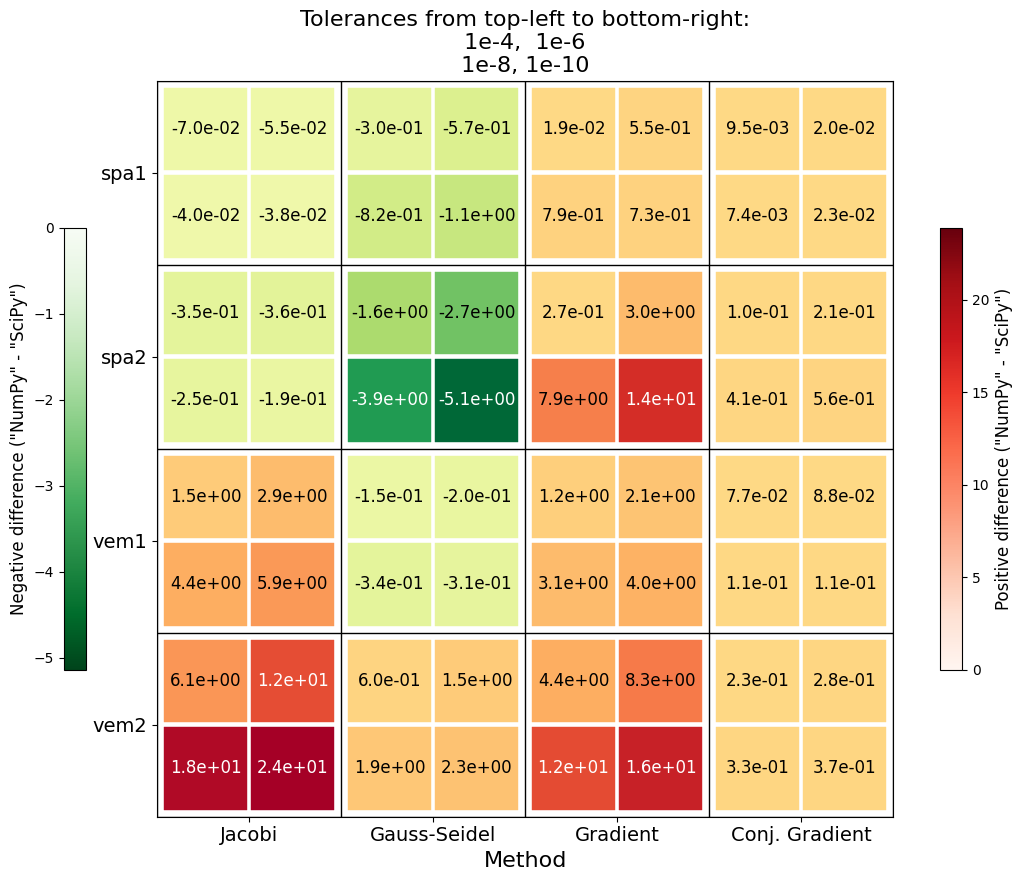

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import os

def get_contrasting_text_color(rgb):
    """Returns 'white' if the background color is dark, else 'black'."""
    r, g, b = rgb[:3]
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'white' if luminance < 0.5 else 'black'

# Setup
path_base = "plot_data_dense\\"
path_base_sparse = "plot_data_sparse\\"

matrices = ["spa1", "spa2", "vem1", "vem2"]
methods = ["jacobi", "gs", "gradient", "gradconj"]
methods_ticks = ["Jacobi", "Gauss-Seidel", "Gradient", "Conj. Gradient"]
tols = ["0.0001", "1e-06", "1e-08", "1e-10"]
tols_display = ["1e-4", "1e-6", "1e-8", "1e-10"]

num_matrices = len(matrices)
num_methods = len(methods)
num_tols = len(tols)

# Load data: shape (matrices, methods, tolerances)
times = np.zeros((num_matrices, num_methods, num_tols))
for i, mat in enumerate(matrices):
    for j, method in enumerate(methods):
        for k, tol in enumerate(tols):
            filepath = os.path.join(path_base, f"{mat}_{method}_{tol}.npy")
            data = np.load(filepath, allow_pickle=True).item()
            times[i, j, k] = data["time"]


# Load data: shape (matrices, methods, tolerances)
times2 = np.zeros((num_matrices, num_methods, num_tols))
for i, mat in enumerate(matrices):
    for j, method in enumerate(methods):
        for k, tol in enumerate(tols):
            filepath = os.path.join(path_base_sparse, f"{mat}.mtx_{method}_{tol}.npy")
            data2 = np.load(filepath, allow_pickle=True).item()
            times2[i, j, k] = data2["time"]

times = times - times2

# Normalize for colormap
vmin, vmax = np.min(times), np.max(times)
cmap = plt.get_cmap("Blues")
cmap = plt.get_cmap("RdYlGn_r")  # reversed: green for low, red for high


base = plt.get_cmap('RdYlGn_r')
colors = base(np.linspace(0, 1, 256))

# Stretch green region (left side), compress red (right side)
# This will "pull" more of the color resolution toward negative values
shifted = np.concatenate([
    colors[:120],              # more green (0–~0.4)
    colors[140:],              # less yellow and red
])

cmap = LinearSegmentedColormap.from_list("stretched", shifted)



# Main plot
fig, ax = plt.subplots(figsize=(12, 8))
mini_size = 0.45
spacing = 0.05

# Tolerance positions in 2x2 layout
pos_map = {
    0: (0, 1),  # 1e-4
    1: (1, 1),  # 1e-6
    2: (0, 0),  # 1e-8
    3: (1, 0)   # 1e-10
}

#norm = LogNorm(vmin=max(vmin, 3e-2), vmax=vmax)  # Avoid log(0)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0.1, vmax=vmax)

vmin_neg = np.min(times[times < 0]) if np.any(times < 0) else 0
vmax_pos = np.max(times[times > 0]) if np.any(times > 0) else 0

# Draw heatmap squares
for i in range(num_matrices):
    for j in range(num_methods):
        for k in range(num_tols):
            val = times[i, j, k]
            norm_val = np.sqrt(val - vmin) / np.sqrt(vmax - vmin)

            if val < 0:
                norm_val = 0.5 * (val - vmin_neg) / (0 - vmin_neg)  # maps [vmin_neg, 0] → [0, 0.5]
            elif val > 0:
                norm_val = 0.58 + 0.52 * (val / vmax_pos)             # maps [0, vmax_pos] → [0.5, 1.0]
            else:
                norm_val = 0.5  # neutral color for 0


            color = cmap(norm_val)
            # Center 2x2 grid inside each main cell
            grid_width = 2 * mini_size + spacing / 2
            grid_height = 2 * mini_size + spacing / 2

            x0 = j + (1 - grid_width) / 2
            y0 = i + (1 - grid_height) / 2

            col_shift, row_shift = pos_map[k]
            x = x0 + col_shift * (mini_size + spacing / 2)
            y = y0 + (1 - row_shift) * (mini_size + spacing / 2)

            rect = plt.Rectangle((x, y), mini_size, mini_size,
                                 color=color, edgecolor='black', linewidth=0.3)
            ax.add_patch(rect)

            # Format in scientific notation
            text_color = get_contrasting_text_color(color)
            ax.text(
                x + mini_size / 2,
                y + mini_size / 2,
                f"{val:.1e}",
                ha='center',
                va='center',
                fontsize=12,
                color=text_color
            )

# Axes
ax.set_xticks([j + 0.5 for j in range(num_methods)])
ax.set_yticks([i + 0.5 for i in range(num_matrices)])
ax.set_xticklabels(methods_ticks, fontsize=14)
ax.set_yticklabels(matrices, fontsize=14)
ax.set_xlim(0, num_methods)
ax.set_ylim(0, num_matrices)
ax.set_xlabel("Method", fontsize=16)
ax.set_ylabel("Matrix", fontsize=16)
ax.set_title("Tolerances from top-left to bottom-right:\n 1e-4,  1e-6 \n 1e-8, 1e-10 ", fontsize=16)
ax.invert_yaxis()
ax.set_aspect("equal")

'''# Colorbar
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Time (s)", fontsize=14)
cbar.ax.tick_params(labelsize=12)'''




# Define two separate normalizations
vmin_neg = np.min(times[times < 0]) if np.any(times < 0) else 0
vmax_pos = np.max(times[times > 0]) if np.any(times > 0) else 0

# Separate colormaps
cmap_neg = plt.get_cmap("Greens_r")
cmap_pos = plt.get_cmap("Reds")

# Create scalar mappables for colorbars
norm_neg = Normalize(vmin=vmin_neg, vmax=0)
sm_neg = ScalarMappable(norm=norm_neg, cmap=cmap_neg)
sm_neg.set_array([])

norm_pos = Normalize(vmin=0, vmax=vmax_pos)
sm_pos = ScalarMappable(norm=norm_pos, cmap=cmap_pos)
sm_pos.set_array([])

# Add negative colorbar (left)
cbar_neg = fig.colorbar(sm_neg, ax=ax, location='left', shrink=0.6, pad=0.05)
cbar_neg.set_label("Negative difference (\"NumPy\" - \"SciPy\")", fontsize=12)
cbar_neg.ax.tick_params(labelsize=10)

# Add positive colorbar (right)
cbar_pos = fig.colorbar(sm_pos, ax=ax, location='right', shrink=0.6, pad=0.05)
cbar_pos.set_label("Positive difference (\"NumPy\" - \"SciPy\")", fontsize=12)
cbar_pos.ax.tick_params(labelsize=10)



for k, tol_str in enumerate(tols_display):
    col_shift, row_shift = pos_map[k]
    x = col_shift * (mini_size + spacing / 2)
    y = (1 - row_shift) * (mini_size + spacing / 2)
    square = plt.Rectangle((x, y), mini_size, mini_size,
                           color="lightgray", edgecolor="black", linewidth=0.5)

plt.tight_layout()
# Add black grid lines around each matrix-method cell
for i in range(num_matrices + 1):
    ax.plot([0, num_methods], [i, i], color='black', linewidth=1)  # horizontal lines
for j in range(num_methods + 1):
    ax.plot([j, j], [0, num_matrices], color='black', linewidth=1)  # vertical lines

# Padding fix – top & bottom
fig.subplots_adjust(top=0.92, bottom=0)  # Adjust as needed


#plt.subplots_adjust(bottom=0.15)
plt.show()

### Number of iterations

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_48720\1301373647.py:73: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = plt.Rectangle((x, y), mini_size, mini_size,
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_48720\1301373647.py:118: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  square = plt.Rectangle((x, y), mini_size, mini_size,


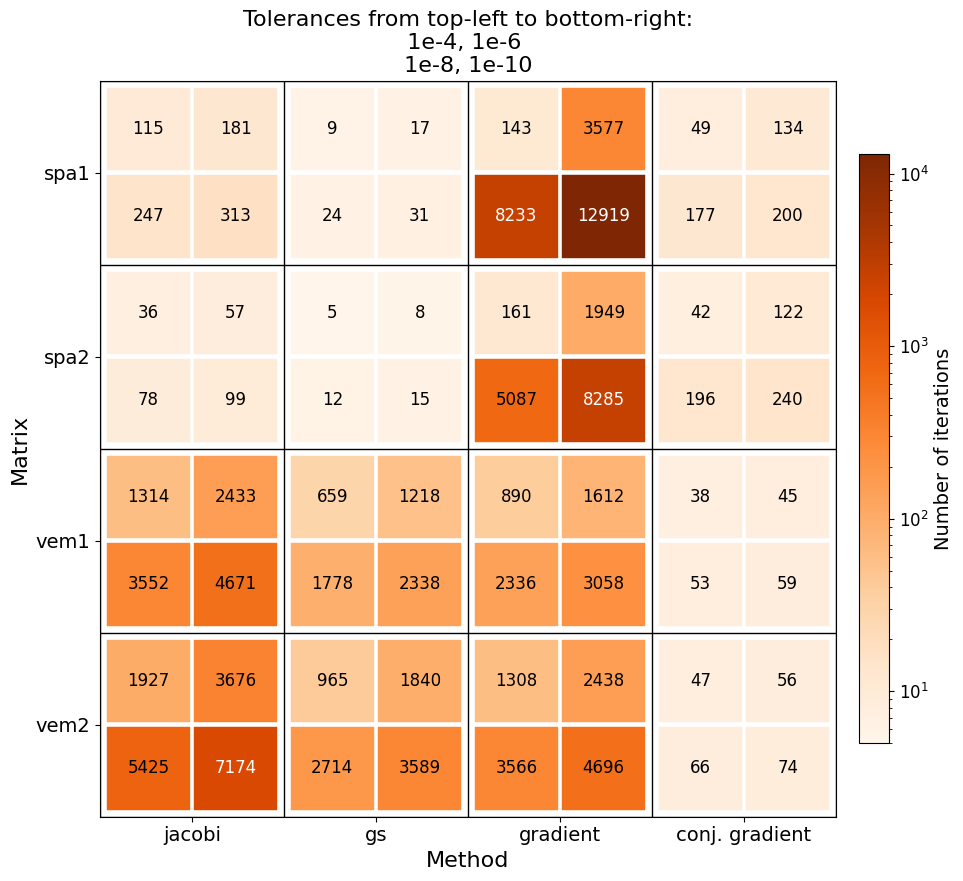

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

def get_contrasting_text_color(rgb):
    """Returns 'white' if the background color is dark, else 'black'."""
    r, g, b = rgb[:3]
    luminance = 0.299 * r + 0.587 * g + 0.114 * b
    return 'white' if luminance < 0.5 else 'black'

# Setup
path_base = "plot_data_dense\\"

matrices = ["spa1", "spa2", "vem1", "vem2"]
methods = ["jacobi", "gs", "gradient", "gradconj"]
methods_ticks = ["jacobi", "gs", "gradient", "conj. gradient"]
tols = ["0.0001", "1e-06", "1e-08", "1e-10"]
tols_display = ["1e-4", "1e-6", "1e-8", "1e-10"]

num_matrices = len(matrices)
num_methods = len(methods)
num_tols = len(tols)

# Load data: shape (matrices, methods, tolerances)
times = np.zeros((num_matrices, num_methods, num_tols))
for i, mat in enumerate(matrices):
    for j, method in enumerate(methods):
        for k, tol in enumerate(tols):
            filepath = os.path.join(path_base, f"{mat}_{method}_{tol}.npy")
            data = np.load(filepath, allow_pickle=True).item()
            times[i, j, k] = data["nit"]

# Normalize for colormap
vmin, vmax = np.min(times), np.max(times)
cmap = plt.get_cmap("Oranges")

# Main plot
fig, ax = plt.subplots(figsize=(12, 8))
mini_size = 0.45
spacing = 0.05

# Tolerance positions in 2x2 layout
pos_map = {
    0: (0, 1),  # 1e-4
    1: (1, 1),  # 1e-6
    2: (0, 0),  # 1e-8
    3: (1, 0)   # 1e-10
}

norm = LogNorm(vmin=max(vmin, 100), vmax=vmax)

# Draw heatmap squares
for i in range(num_matrices):
    for j in range(num_methods):
        for k in range(num_tols):
            val = times[i, j, k]
            #norm_val = (val - vmin) / (vmax - vmin + 1e-8)
            norm_val = norm(val)
            norm_val = np.sqrt(val - vmin) / np.sqrt(vmax - vmin)
            color = cmap(norm_val)
            # Center 2x2 grid inside each main cell
            grid_width = 2 * mini_size + spacing / 2
            grid_height = 2 * mini_size + spacing / 2

            x0 = j + (1 - grid_width) / 2
            y0 = i + (1 - grid_height) / 2

            col_shift, row_shift = pos_map[k]
            x = x0 + col_shift * (mini_size + spacing / 2)
            y = y0 + (1 - row_shift) * (mini_size + spacing / 2)

            rect = plt.Rectangle((x, y), mini_size, mini_size,
                                 color=color, edgecolor='black', linewidth=0.3)
            ax.add_patch(rect)

            # Format in scientific notation
            text_color = get_contrasting_text_color(color)
            ax.text(
                x + mini_size / 2,
                y + mini_size / 2,
                int(val),
                ha='center',
                va='center',
                fontsize=12,
                color=text_color
            )

# Axes
ax.set_xticks([j + 0.5 for j in range(num_methods)])
ax.set_yticks([i + 0.5 for i in range(num_matrices)])
ax.set_xticklabels(methods_ticks, fontsize=14)
ax.set_yticklabels(matrices, fontsize=14)
ax.set_xlim(0, num_methods)
ax.set_ylim(0, num_matrices)
ax.set_xlabel("Method", fontsize=16)
ax.set_ylabel("Matrix", fontsize=16)
ax.set_title("Tolerances from top-left to bottom-right:\n  1e-4, 1e-6   \n 1e-8, 1e-10 ", fontsize=16)
ax.invert_yaxis()
ax.set_aspect("equal")

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
cbar = plt.colorbar(sm, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Number of iterations", fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Tolerance legend (below plot)
#legend_ax = fig.add_axes([0.35, -0.12, 0.3, 0.15])  # [left, bottom, width, height]
#legend_ax.axis("off")
#legend_ax.set_title("Tolerance layout", fontsize=10)

for k, tol_str in enumerate(tols_display):
    col_shift, row_shift = pos_map[k]
    x = col_shift * (mini_size + spacing / 2)
    y = (1 - row_shift) * (mini_size + spacing / 2)
    square = plt.Rectangle((x, y), mini_size, mini_size,
                           color="lightgray", edgecolor="black", linewidth=0.5)
    #legend_ax.add_patch(square)
    #legend_ax.text(x + mini_size / 2, y + mini_size / 2, tol_str,
    #               ha='center', va='center', fontsize=8)

plt.tight_layout()
# Add black grid lines around each matrix-method cell
for i in range(num_matrices + 1):
    ax.plot([0, num_methods], [i, i], color='black', linewidth=1)  # horizontal lines
for j in range(num_methods + 1):
    ax.plot([j, j], [0, num_matrices], color='black', linewidth=1)  # vertical lines

# Padding fix – top & bottom
fig.subplots_adjust(top=0.92, bottom=0)  # Adjust as needed


#plt.subplots_adjust(bottom=0.15)
plt.show()